# QR 코드 피싱 탐지 모델 성능 평가

학습된 CNN 모델의 성능을 평가합니다. 다음 지표들을 계산합니다:
- 정확도 (Accuracy)
- 정밀도 (Precision)
- 재현율 (Recall)
- F1 점수
- 혼동 행렬 (Confusion Matrix)

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
model_path = '../best_model.h5'
model = tf.keras.models.load_model(model_path)
print("모델 로드 완료")

test_dir = '../data/images'  # change me
batch_size = 6  # chage me

모델 로드 완료


In [7]:
def preprocess_image(image_path, target_size=(128, 128)):
    """이미지를 전처리하는 함수"""
    img = load_img(image_path, color_mode='grayscale', target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def evaluate_model(test_dir, batch_size=32):
    """모델 성능 평가 함수"""
    y_true = []
    y_pred = []
    y_pred_prob = []
    
    # 이미지 경로 미리 수집
    def collect_image_paths(directory):
        paths = []
        for img_name in os.listdir(directory):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                paths.append(os.path.join(directory, img_name))
        return paths
    
    # 배치 단위로 이미지 처리
    def process_batch(paths, label):
        batch_images = []
        for path in paths:
            img = load_img(path, color_mode='grayscale', target_size=(128, 128))
            img_array = img_to_array(img)
            img_array = img_array / 255.0
            batch_images.append(img_array)
            
        if batch_images:
            batch_array = np.array(batch_images)
            pred = model.predict(batch_array, verbose=0, batch_size=batch_size)
            
            y_true.extend([label] * len(paths))
            y_pred.extend([1 if p[1] > 0.5 else 0 for p in pred])
            y_pred_prob.extend([p[1] for p in pred])
            
            # 메모리 해제
            del batch_array
            del batch_images
            tf.keras.backend.clear_session()
    
    # 정상 QR 코드 평가
    benign_paths = collect_image_paths(os.path.join(test_dir, 'benign'))
    for i in range(0, len(benign_paths), batch_size):
        batch_paths = benign_paths[i:i+batch_size]
        process_batch(batch_paths, 0)  # benign = 0
        
    # 피싱 QR 코드 평가
    phishing_paths = collect_image_paths(os.path.join(test_dir, 'phishing'))
    for i in range(0, len(phishing_paths), batch_size):
        batch_paths = phishing_paths[i:i+batch_size]
        process_batch(batch_paths, 1)  # phishing = 1
    
    return np.array(y_true), np.array(y_pred), np.array(y_pred_prob)

In [8]:
# 모델 평가
y_true, y_pred, y_pred_prob = evaluate_model(test_dir, batch_size=batch_size)

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 결과 출력
print("=== 모델 성능 평가 결과 ===")
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"정밀도 (Precision): {precision:.4f}")
print(f"재현율 (Recall): {recall:.4f}")
print(f"F1 점수: {f1:.4f}")

=== 모델 성능 평가 결과 ===
정확도 (Accuracy): 0.8710
정밀도 (Precision): 0.8552
재현율 (Recall): 0.8934
F1 점수: 0.8739


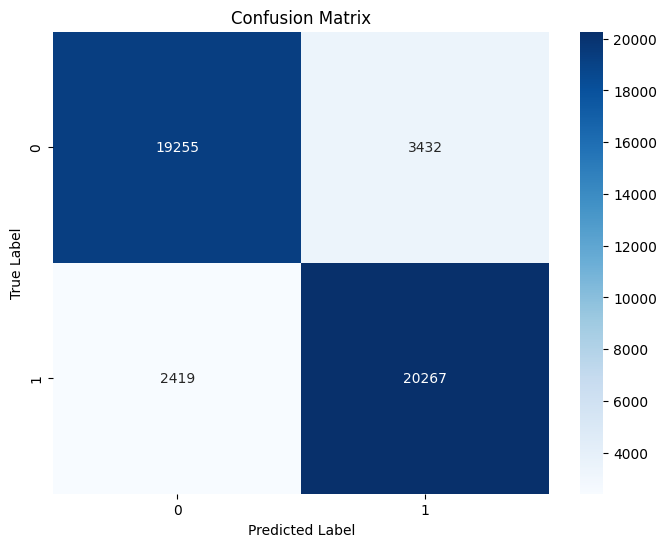


=== Confusion Matrix Description ===
True Negative: 19255
False Positive: 3432
False Negative: 2419
True Positive: 20267


In [13]:
# Confusion Matrix stats
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n=== Confusion Matrix Description ===")
print(f"True Negative: {cm[0][0]}")
print(f"False Positive: {cm[0][1]}")
print(f"False Negative: {cm[1][0]}")
print(f"True Positive: {cm[1][1]}")

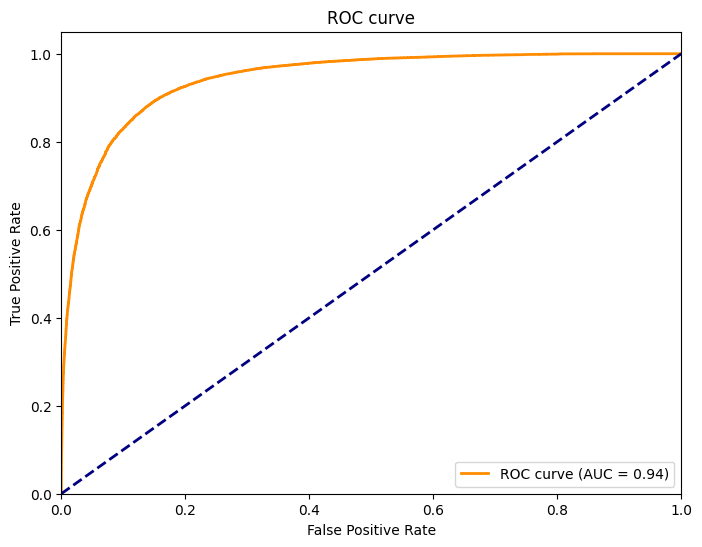

In [ ]:
# ROC curve stats
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()